In [1]:
import timeit
#TODO remove
import warnings
import pandas as pd
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.6f' % x)
stime = timeit.default_timer()

In [2]:
import math
import mldatasets
import pandas as pd
import sqlite3
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics, linear_model, tree, naive_bayes, neighbors, ensemble,\
                    neural_network, svm, decomposition, manifold
from rulefit import RuleFit
from cvae import cvae
import statsmodels.api as sm
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from interpret.perf import ROC
from skrules import SkopeRules
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [3]:
adc18_df = mldatasets.load("airline-delays-and-cancellations-2018")

297485%2F609497%2Fcompressed%2F2018.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
/Users/serg/EXTEND/PROJECTS/InterpretableMLBook/programming/Chapter3/data/297485%2F609497%2Fcompressed%2F2018.csv.zip uncompressed to /Users/serg/EXTEND/PROJECTS/InterpretableMLBook/programming/Chapter3/data/airline-delay-and-cancellation-data-2009-2018
1 dataset files found in /Users/serg/EXTEND/PROJECTS/InterpretableMLBook/programming/Chapter3/data/airline-delay-and-cancellation-data-2009-2018 folder
parsing /Users/serg/EXTEND/PROJECTS/InterpretableMLBook/programming/Chapter3/data/airline-delay-and-cancellation-data-2009-2018/2018.csv


In [4]:
adc18_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7213446 entries, 0 to 7213445
Data columns (total 27 columns):
FL_DATE                object
OP_CARRIER             object
OP_CARRIER_FL_NUM      int64
ORIGIN                 object
DEST                   object
CRS_DEP_TIME           int64
DEP_TIME               float64
DEP_DELAY              float64
TAXI_OUT               float64
WHEELS_OFF             float64
WHEELS_ON              float64
TAXI_IN                float64
CRS_ARR_TIME           int64
ARR_TIME               float64
ARR_DELAY              float64
CANCELLED              float64
CANCELLATION_CODE      object
DIVERTED               float64
CRS_ELAPSED_TIME       float64
ACTUAL_ELAPSED_TIME    float64
AIR_TIME               float64
DISTANCE               float64
CARRIER_DELAY          float64
WEATHER_DELAY          float64
NAS_DELAY              float64
SECURITY_DELAY         float64
LATE_AIRCRAFT_DELAY    float64
dtypes: float64(19), int64(3), object(5)
memory usage: 1.5+ G

In [5]:
adc18_df = adc18_df[adc18_df['CANCELLED']==0]
adc18_df = adc18_df.drop(['CANCELLED', 'CANCELLATION_CODE'], axis=1).reset_index()
adc18_df['CARRIER_DELAY'] = adc18_df['CARRIER_DELAY'].fillna(0)
adc18_df['WEATHER_DELAY'] = adc18_df['WEATHER_DELAY'].fillna(0)
adc18_df['LATE_AIRCRAFT_DELAY'] = adc18_df['LATE_AIRCRAFT_DELAY'].fillna(0)
adc18_df['SECURITY_DELAY'] = adc18_df['SECURITY_DELAY'].fillna(0)
adc18_df['NAS_DELAY'] = adc18_df['NAS_DELAY'].fillna(0)

In [6]:
adc18_df['PLANNED_DEP_DATETIME'] = pd.to_datetime(\
    adc18_df['FL_DATE'].str.cat(\
    adc18_df['CRS_DEP_TIME'].astype(int).astype(str).apply(lambda x: x.zfill(4)[:2] + ':' + x.zfill(4)[-2:] )\
    , sep=' '))

In [7]:
adc18_df['ACTUAL_DEP_DATETIME'] = adc18_df['PLANNED_DEP_DATETIME'] + \
pd.to_timedelta(adc18_df['DEP_DELAY'].fillna(0), unit='m')

In [8]:
#Pandas can't convert dates that are YYYY-MM-DD 24:00. If you change hour to 00:00 it works
adc18_df.loc[adc18_df.CRS_ARR_TIME == 2400, 'CRS_ARR_TIME'] = 0 
#Join FL_DATE and CRS_ARR_TIME to form PLANNED_ARR_DATETIME
adc18_df['PLANNED_ARR_DATETIME'] = pd.to_datetime(\
    adc18_df['FL_DATE'].str.cat(\
    adc18_df['CRS_ARR_TIME'].astype(int).astype(str).apply(lambda x: x.zfill(4)[:2] + ':' + x.zfill(4)[-2:])\
    , sep=' '))
#Add a day for most flights that arrive before they took off
arrived_before = (adc18_df['PLANNED_ARR_DATETIME'] - adc18_df['PLANNED_DEP_DATETIME']).astype('timedelta64[m]') < -40
adc18_df.loc[arrived_before, 'PLANNED_ARR_DATETIME'] = \
adc18_df.loc[arrived_before, 'PLANNED_ARR_DATETIME'] + pd.DateOffset(days=1)
#Deduct a day only flights that crossed the international date line going east
gum_to_hnl = (adc18_df['ORIGIN'] == 'GUM') & (adc18_df['DEST'] == 'HNL')
adc18_df.loc[gum_to_hnl, 'PLANNED_ARR_DATETIME'] = \
adc18_df.loc[gum_to_hnl, 'PLANNED_ARR_DATETIME'] - pd.DateOffset(days=1)

In [9]:
adc18_df['ACTUAL_ARR_DATETIME'] = adc18_df['PLANNED_ARR_DATETIME'] + \
pd.to_timedelta(adc18_df['ARR_DELAY'].fillna(0), unit='m')

In [10]:
adc18_airportsdates_df = pd.concat([adc18_df[['ORIGIN','ACTUAL_DEP_DATETIME']].\
                            rename(columns={'ORIGIN': 'AIRPORT', 'ACTUAL_DEP_DATETIME':'DATE'}),
                          adc18_df[['DEST','ACTUAL_ARR_DATETIME']].\
                            rename(columns={'DEST': 'AIRPORT', 'ACTUAL_ARR_DATETIME':'DATE'})
                         ])
adc18_airportsdates_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14193724 entries, 0 to 7096861
Data columns (total 2 columns):
AIRPORT    object
DATE       datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 324.9+ MB


In [11]:
adc18_airportsdates_df['MONTH'] = adc18_airportsdates_df['DATE'].dt.month
adc18_airportsdates_df['DOW'] = adc18_airportsdates_df['DATE'].dt.dayofweek
adc18_airportsdates_df['DAY'] = adc18_airportsdates_df['DATE'].dt.day
adc18_airportsdates_df['HOUR'] = adc18_airportsdates_df['DATE'].dt.hour
adc18_airportsdates_df = adc18_airportsdates_df.drop(['DATE'], axis=1)
adc18_airportbusyness_df = adc18_airportsdates_df.groupby(['AIRPORT', 'MONTH', 'DOW', 'DAY', 'HOUR']).\
    size().reset_index(name='totals').groupby(['AIRPORT', 'MONTH', 'DOW', 'HOUR']).\
    agg({'totals':'median'}).rename(columns={'totals':'MedFPH'}).reset_index()

In [12]:
adc18_df['OP_CARRIER_FL_NUM'] = adc18_df['OP_CARRIER_FL_NUM'].astype(str)
adc18_df['FL_ID'] = adc18_df['OP_CARRIER'] + adc18_df['OP_CARRIER_FL_NUM'] +\
                        '_' + adc18_df['ORIGIN'] + '-' + adc18_df['DEST']

In [13]:
adc18_aa_df = adc18_df[(adc18_df['OP_CARRIER'] == 'AA') & (adc18_df['DIVERTED']==0)].copy()
adc18_aa_df = adc18_aa_df.drop(['DIVERTED', 'index'], axis=1)

In [14]:
adc18_aa_df['PLANNED_DEP_DATETIME_PAD'] = adc18_aa_df['PLANNED_DEP_DATETIME'] - pd.DateOffset(minutes=30)
adc18_aa_df['PLANNED_ARR_DATETIME_PAD'] = adc18_aa_df['PLANNED_ARR_DATETIME'] - pd.DateOffset(minutes=30)
adc18_aa_df['ACTUAL_DEP_DATETIME_PAD'] = adc18_aa_df['ACTUAL_DEP_DATETIME'] + pd.DateOffset(minutes=30)
adc18_aa_df['ACTUAL_ARR_DATETIME_PAD'] = adc18_aa_df['ACTUAL_ARR_DATETIME'] + pd.DateOffset(minutes=30)

In [15]:
dep_cols1 = ['FL_DATE', 'FL_ID', 'ORIGIN', 'PLANNED_DEP_DATETIME_PAD', 'ACTUAL_DEP_DATETIME_PAD']
dep_cols2 = ['ORIGIN', 'ACTUAL_DEP_DATETIME']
dep1_df = adc18_aa_df[dep_cols1].copy().set_index(dep_cols1)
dep2_df = adc18_df[dep_cols2].copy().set_index(dep_cols2)

In [16]:
arr_cols1 = ['FL_DATE', 'FL_ID', 'DEST', 'PLANNED_ARR_DATETIME_PAD', 'ACTUAL_ARR_DATETIME_PAD']
arr_cols2 = ['DEST', 'ACTUAL_ARR_DATETIME']
arr1_df = adc18_aa_df[arr_cols1].copy().set_index(arr_cols1)
arr2_df = adc18_df[arr_cols2].copy().set_index(arr_cols2)

In [17]:
#Create a DB in memory
conn = sqlite3.connect(':memory:')
#Write the dataframes as tables
dep1_df.to_sql('dep1_df', conn)
dep2_df.to_sql('dep2_df', conn)
arr1_df.to_sql('arr1_df', conn)
arr2_df.to_sql('arr2_df', conn)
#Delete dataframes (no longer needed)
del dep1_df, dep2_df, arr1_df, arr2_df, adc18_df, adc18_airportsdates_df

In [18]:
dep1_sql = '''
select A.FL_DATE, A.FL_ID, count(*) AS TOTAL_DEP1_FLIGHTS
from dep1_df A
join dep2_df B on A.ORIGIN = B.ORIGIN AND 
B.ACTUAL_DEP_DATETIME between A.PLANNED_DEP_DATETIME_PAD AND A.ACTUAL_DEP_DATETIME_PAD
group by A.FL_DATE, A.FL_ID
'''
total_dep1_df = pd.read_sql_query(dep1_sql, conn)

In [19]:
dep2_sql = '''
select A.FL_DATE, A.FL_ID, count(*) AS TOTAL_DEP2_FLIGHTS
from dep1_df A
join arr2_df C on A.ORIGIN = C.DEST and 
C.ACTUAL_ARR_DATETIME between A.PLANNED_DEP_DATETIME_PAD and A.ACTUAL_DEP_DATETIME_PAD
group by A.FL_DATE, A.FL_ID
'''
total_dep2_df = pd.read_sql_query(dep2_sql, conn)

In [20]:
arr1_sql = '''
select A.FL_DATE, A.FL_ID, count(*) AS TOTAL_ARR1_FLIGHTS
from arr1_df A
join arr2_df B on A.DEST = B.DEST AND 
A.PLANNED_ARR_DATETIME_PAD < A.ACTUAL_ARR_DATETIME_PAD and
B.ACTUAL_ARR_DATETIME between A.PLANNED_ARR_DATETIME_PAD and A.ACTUAL_ARR_DATETIME_PAD
group by A.FL_DATE, A.FL_ID
'''
total_arr1_df = pd.read_sql_query(arr1_sql, conn)

In [21]:
arr2_sql = '''
select A.FL_DATE, A.FL_ID, count(*) AS TOTAL_ARR2_FLIGHTS
from arr1_df A
inner join dep2_df B on A.DEST = B.ORIGIN and 
B.ACTUAL_DEP_DATETIME between A.PLANNED_ARR_DATETIME_PAD and A.ACTUAL_ARR_DATETIME_PAD
group by A.FL_DATE, A.FL_ID
'''
total_arr2_df = pd.read_sql_query(arr2_sql, conn)

In [22]:
adc18_aa_df = pd.merge(adc18_aa_df,
                pd.merge(
                         pd.merge(total_dep1_df, total_dep2_df, 'outer'), 
                         pd.merge(total_arr1_df, total_arr2_df, 'outer'), 
                    'outer').fillna(0),
                'left')
del total_dep1_df, total_dep2_df, total_arr1_df, total_arr2_df
conn.close()

In [23]:
adc18_aa_df['TOTAL_DEP_FLIGHTS'] = adc18_aa_df['TOTAL_DEP1_FLIGHTS'] + adc18_aa_df['TOTAL_DEP2_FLIGHTS']
adc18_aa_df['TOTAL_ARR_FLIGHTS'] = adc18_aa_df['TOTAL_ARR1_FLIGHTS'] + adc18_aa_df['TOTAL_ARR2_FLIGHTS']

In [24]:
adc18_aa_df['TOTAL_DEP_HOURS'] = (adc18_aa_df['ACTUAL_DEP_DATETIME_PAD'] - adc18_aa_df['PLANNED_DEP_DATETIME_PAD']).astype('timedelta64[m]')/60
adc18_aa_df['TOTAL_ARR_HOURS'] = (adc18_aa_df['ACTUAL_ARR_DATETIME_PAD'] - adc18_aa_df['PLANNED_ARR_DATETIME_PAD']).astype('timedelta64[m]')/60

In [25]:
adc18_aa_df['DEP_AFPH'] = adc18_aa_df['TOTAL_DEP_FLIGHTS'] / adc18_aa_df['TOTAL_DEP_HOURS']
adc18_aa_df['ARR_AFPH'] = adc18_aa_df['TOTAL_ARR_FLIGHTS'] / adc18_aa_df['TOTAL_ARR_HOURS']
adc18_aa_df['ARR_AFPH'] = adc18_aa_df['ARR_AFPH'].replace([np.inf, -np.inf], np.nan).fillna(0)

In [26]:
adc18_aa_df = adc18_aa_df.drop(['PLANNED_DEP_DATETIME_PAD', 'PLANNED_ARR_DATETIME_PAD', 'ACTUAL_DEP_DATETIME_PAD', 
                                'ACTUAL_ARR_DATETIME_PAD', 'TOTAL_DEP1_FLIGHTS', 'TOTAL_ARR1_FLIGHTS', 
                                'TOTAL_DEP2_FLIGHTS', 'TOTAL_ARR2_FLIGHTS', 'TOTAL_DEP_FLIGHTS', 'TOTAL_ARR_FLIGHTS', 
                                'TOTAL_DEP_HOURS', 'TOTAL_ARR_HOURS'], axis=1)

In [27]:
adc18_aa_df['DEP_MONTH'] = adc18_aa_df['ACTUAL_DEP_DATETIME'].dt.month
adc18_aa_df['DEP_DOW'] = adc18_aa_df['ACTUAL_DEP_DATETIME'].dt.dayofweek
adc18_aa_df['DEP_HOUR'] = adc18_aa_df['ACTUAL_DEP_DATETIME'].dt.hour
adc18_aa_df['ARR_MONTH'] = adc18_aa_df['ACTUAL_ARR_DATETIME'].dt.month
adc18_aa_df['ARR_DOW'] = adc18_aa_df['ACTUAL_ARR_DATETIME'].dt.dayofweek
adc18_aa_df['ARR_HOUR'] = adc18_aa_df['ACTUAL_ARR_DATETIME'].dt.hour

In [28]:
adc18_aa_df = pd.merge(adc18_aa_df, adc18_airportbusyness_df,\
                   left_on=['ORIGIN', 'DEP_MONTH', 'DEP_DOW', 'DEP_HOUR'],\
                   right_on=['AIRPORT', 'MONTH', 'DOW', 'HOUR'], how = 'left').\
        rename(columns={'MedFPH':'DEP_MedFPH'}).\
        drop(['AIRPORT', 'MONTH', 'DOW', 'HOUR', 'DEP_HOUR'], axis=1)
adc18_aa_df = pd.merge(adc18_aa_df, adc18_airportbusyness_df,\
                   left_on=['DEST', 'ARR_MONTH', 'ARR_DOW', 'ARR_HOUR'],\
                   right_on=['AIRPORT', 'MONTH', 'DOW', 'HOUR'], how = 'left').\
        rename(columns={'MedFPH':'ARR_MedFPH'}).\
        drop(['AIRPORT', 'MONTH', 'DOW', 'HOUR','ARR_MONTH', 'ARR_DOW', 'ARR_HOUR'], axis=1)

In [29]:
rand = 9
adc18_aa_df.sample(n=10, random_state=rand)[['FL_DATE', 'FL_ID', 'DEP_AFPH',\
                                             'DEP_MedFPH', 'ARR_AFPH', 'ARR_MedFPH']]

,FL_DATE,FL_ID,DEP_AFPH,DEP_MedFPH,ARR_AFPH,ARR_MedFPH
427955,2018-06-25,AA2559_DTW-DFW,71.186441,72.500000,114.461538,100.500000
387414,2018-06-09,AA2036_LGA-CLT,41.666667,51.000000,73.125000,55.000000
719773,2018-10-19,AA2536_MSY-DFW,27.457627,28.500000,111.864407,101.500000
613659,2018-09-06,AA1298_BNA-LAX,20.377358,28.000000,90.000000,90.500000
526641,2018-08-03,AA1018_IND-DFW,19.000000,21.000000,98.823529,106.000000
10887,2018-01-05,AA265_LAX-LIH,77.142857,81.000000,11.250000,7.500000
547972,2018-08-11,AA1309_DFW-ATL,77.454545,87.500000,118.846154,120.000000
743293,2018-10-28,AA422_MCO-DFW,50.357143,48.500000,93.061224,69.000000
301172,2018-05-06,AA1361_ORD-BDL,117.187500,119.500000,4.067797,4.000000
73031,2018-02-01,AA1364_ORD-PBI,121.052632,82.000000,17.894737,14.000000


In [30]:
adc18_aa_df['DEP_RFPH'] = adc18_aa_df['DEP_AFPH'] / adc18_aa_df['DEP_MedFPH']
adc18_aa_df['ARR_RFPH'] = adc18_aa_df['ARR_AFPH'] / adc18_aa_df['ARR_MedFPH']

In [31]:
#Create list with 10 hubs
hubs = ['CLT', 'ORD', 'DFW', 'LAX', 'MIA', 'JFK', 'LGA', 'PHL', 'PHX', 'DCA']
#Boolean series for if ORIGIN or DEST are hubs
is_origin_hub = adc18_aa_df['ORIGIN'].isin(hubs)
is_dest_hub = adc18_aa_df['DEST'].isin(hubs)
#Use boolean series to set ORIGIN_HUB and DEST_HUB
adc18_aa_df['ORIGIN_HUB'] = 0
adc18_aa_df.loc[is_origin_hub, 'ORIGIN_HUB'] = 1
adc18_aa_df['DEST_HUB'] = 0
adc18_aa_df.loc[is_dest_hub, 'DEST_HUB'] = 1
#Delete columns with codes
adc18_aa_df = adc18_aa_df.drop(['OP_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST', 'FL_ID'], axis=1)

In [32]:
adc18_aa_df['PCT_ELAPSED_TIME'] = adc18_aa_df['ACTUAL_ELAPSED_TIME'] / adc18_aa_df['CRS_ELAPSED_TIME']
adc18_aa_df = adc18_aa_df.drop(['PLANNED_DEP_DATETIME', 'ACTUAL_DEP_DATETIME', 'PLANNED_ARR_DATETIME',\
                                'ACTUAL_ARR_DATETIME', 'FL_DATE', 'DEP_MedFPH', 'ARR_MedFPH'], axis=1)
#Count the columns
adc18_aa_df.shape[1]

28

In [33]:
adc18_aa_df.loc[adc18_aa_df['ARR_DELAY'] > 15, ['ARR_DELAY','CARRIER_DELAY']].head(10)

,ARR_DELAY,CARRIER_DELAY
8,168.000000,136.000000
16,20.000000,5.000000
18,242.000000,242.000000
19,62.000000,62.000000
22,19.000000,19.000000
26,26.000000,0.000000
29,77.000000,77.000000
32,19.000000,19.000000
33,18.000000,1.000000
40,36.000000,16.000000


In [34]:
adc18_aa_df = adc18_aa_df.drop(['ARR_DELAY', 'WHEELS_ON', 'TAXI_IN', 'ARR_TIME', 
                                'ACTUAL_ELAPSED_TIME', 'AIR_TIME'], axis=1)
adc18_aa_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 899527 entries, 0 to 899526
Data columns (total 22 columns):
CRS_DEP_TIME           899527 non-null int64
DEP_TIME               899527 non-null float64
DEP_DELAY              899527 non-null float64
TAXI_OUT               899527 non-null float64
WHEELS_OFF             899527 non-null float64
CRS_ARR_TIME           899527 non-null int64
CRS_ELAPSED_TIME       899527 non-null float64
DISTANCE               899527 non-null float64
CARRIER_DELAY          899527 non-null float64
WEATHER_DELAY          899527 non-null float64
NAS_DELAY              899527 non-null float64
SECURITY_DELAY         899527 non-null float64
LATE_AIRCRAFT_DELAY    899527 non-null float64
DEP_AFPH               899527 non-null float64
ARR_AFPH               899527 non-null float64
DEP_MONTH              899527 non-null int64
DEP_DOW                899527 non-null int64
DEP_RFPH               899527 non-null float64
ARR_RFPH               899527 non-null float64
ORIG

In [35]:
y = adc18_aa_df['CARRIER_DELAY']
X = adc18_aa_df.drop(['CARRIER_DELAY'], axis=1).copy()
X_train, X_test, y_train_reg, y_test_reg = train_test_split(X, y, test_size=0.15, random_state=rand)
y_train_class = y_train_reg.apply(lambda x: 1 if x > 15 else 0)
y_test_class = y_test_reg.apply(lambda x: 1 if x > 15 else 0)

In [36]:
corr = adc18_aa_df.corr()
abs(corr['CARRIER_DELAY']).sort_values(ascending=False)

CARRIER_DELAY         1.000000
DEP_DELAY             0.703935
ARR_RFPH              0.101742
LATE_AIRCRAFT_DELAY   0.083166
DEP_RFPH              0.058659
ARR_AFPH              0.035135
DEP_TIME              0.030941
NAS_DELAY             0.026792
WHEELS_OFF            0.026787
TAXI_OUT              0.024635
PCT_ELAPSED_TIME      0.020980
CRS_DEP_TIME          0.016032
ORIGIN_HUB            0.015334
DEST_HUB              0.013932
DISTANCE              0.010680
DEP_MONTH             0.009685
CRS_ELAPSED_TIME      0.008801
CRS_ARR_TIME          0.007029
DEP_AFPH              0.006053
DEP_DOW               0.005545
WEATHER_DELAY         0.003002
SECURITY_DELAY        0.000460
Name: CARRIER_DELAY, dtype: float64

In [37]:
reg_models = {
        #Generalized Linear Models (GLMs)
        'linear':{'model': linear_model.LinearRegression()}, 
        'linear_poly':{'model': make_pipeline(PolynomialFeatures(degree=2),
                              linear_model.LinearRegression(fit_intercept=False)) },
        'linear_interact':{'model': make_pipeline(PolynomialFeatures(interaction_only=True),
                              linear_model.LinearRegression(fit_intercept=False)) },
        'ridge':{'model': linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]) }, 
        #Trees  
        'decision_tree':{'model': tree.DecisionTreeRegressor(max_depth=7, random_state=rand)},
        #RuleFit
        'rulefit':{'model': RuleFit(max_rules=150, rfmode='regress', random_state=rand)}, 
        #Nearest Neighbors
        'knn':{'model': neighbors.KNeighborsRegressor(n_neighbors=7)}, 
        #Ensemble Methods
        'random_forest':{'model':ensemble.RandomForestRegressor(max_depth=7, random_state=rand)}, 
        #Neural Networks
        'mlp':{'model':neural_network.MLPRegressor(hidden_layer_sizes=(21,), max_iter=500, 
                                                   early_stopping=True, random_state=rand)}
    }

In [38]:
for model_name in reg_models.keys():
    if model_name != 'rulefit':
        fitted_model = reg_models[model_name]['model'].fit(X_train, y_train_reg)
    else:
        fitted_model = reg_models[model_name]['model'].fit(X_train.values, y_train_reg.values, X_test.columns)
    y_train_pred = fitted_model.predict(X_train.values)
    y_test_pred = fitted_model.predict(X_test.values)
    reg_models[model_name]['fitted'] = fitted_model
    reg_models[model_name]['preds'] = y_test_pred
    reg_models[model_name]['RMSE_train'] = math.sqrt(metrics.mean_squared_error(y_train_reg, y_train_pred))
    reg_models[model_name]['RMSE_test'] = math.sqrt(metrics.mean_squared_error(y_test_reg, y_test_pred))
    reg_models[model_name]['R2_test'] = metrics.r2_score(y_test_reg, y_test_pred)

In [39]:
reg_metrics = pd.DataFrame.from_dict(reg_models, 'index')[['RMSE_train', 'RMSE_test', 'R2_test']]
reg_metrics.sort_values(by='RMSE_test').style.\
    background_gradient(cmap='viridis', low=1, high=0.3, subset=['RMSE_train', 'RMSE_test']).\
    background_gradient(cmap='plasma', low=0.3, high=1, subset=['R2_test'])

,RMSE_train,RMSE_test,R2_test
mlp,3.18388,3.23262,0.987614
linear_poly,6.21339,6.33494,0.952433
random_forest,5.37769,6.35627,0.952112
linear_interact,6.45271,6.55931,0.949004
decision_tree,6.54292,7.53014,0.932791
linear,7.81963,7.88287,0.926347
ridge,7.92769,7.98758,0.924377
rulefit,8.82055,9.01504,0.903671
knn,7.36014,9.26012,0.898362


In [40]:
class_models = {
        #Generalized Linear Models (GLMs)
        'logistic':{'model': linear_model.LogisticRegression()}, 
        'ridge':{'model': linear_model.RidgeClassifierCV(cv=5, alphas=[1e-3, 1e-2, 1e-1, 1],\
                                                         class_weight='balanced')},  
        #Tree
        'decision_tree':{'model': tree.DecisionTreeClassifier(max_depth=7, random_state=rand)},
        #Nearest Neighbors
        'knn':{'model': neighbors.KNeighborsClassifier(n_neighbors=7)}, 
        #Naive Bayes
        'naive_bayes':{'model': naive_bayes.GaussianNB()},
        #Ensemble Methods
        'gradient_boosting':{'model':ensemble.GradientBoostingClassifier(n_estimators=210)},
        'random_forest':{'model':ensemble.RandomForestClassifier(max_depth=11,\
                                                                 class_weight='balanced', random_state=rand)},
        #Neural Networks
        'mlp':{'model':make_pipeline(StandardScaler(),\
                                     neural_network.MLPClassifier(hidden_layer_sizes=(7,), max_iter=500,\
                                                   early_stopping=True, random_state=rand))}
    }

In [41]:
y_train_class[y_train_class==1].shape[0] / y_train_class.shape[0]

0.061283264255549

In [42]:
for model_name in class_models.keys():
    fitted_model = class_models[model_name]['model'].fit(X_train, y_train_class)
    y_train_pred = fitted_model.predict(X_train.values)
    if model_name == 'ridge':
        y_test_pred = fitted_model.predict(X_test.values) 
    else:
        y_test_prob = fitted_model.predict_proba(X_test.values)[:,1]
        y_test_pred = np.where(y_test_prob > 0.5, 1, 0)
    class_models[model_name]['fitted'] = fitted_model
    class_models[model_name]['probs'] = y_test_prob
    class_models[model_name]['preds'] = y_test_pred
    class_models[model_name]['Accuracy_train'] = metrics.accuracy_score(y_train_class, y_train_pred)
    class_models[model_name]['Accuracy_test'] = metrics.accuracy_score(y_test_class, y_test_pred)
    class_models[model_name]['Recall_train'] = metrics.recall_score(y_train_class, y_train_pred)
    class_models[model_name]['Recall_test'] = metrics.recall_score(y_test_class, y_test_pred)
    if model_name != 'ridge':
        class_models[model_name]['ROC_AUC_test'] = metrics.roc_auc_score(y_test_class, y_test_prob)
    else:
        class_models[model_name]['ROC_AUC_test'] = 0
    class_models[model_name]['F1_test'] = metrics.f1_score(y_test_class, y_test_pred)
    class_models[model_name]['MCC_test'] = metrics.matthews_corrcoef(y_test_class, y_test_pred)

In [43]:
class_metrics = pd.DataFrame.from_dict(class_models, 'index')[['Accuracy_train', 'Accuracy_test',\
                                                               'Recall_train', 'Recall_test',\
                                                               'ROC_AUC_test', 'F1_test', 'MCC_test']]
class_metrics.sort_values(by='ROC_AUC_test', ascending=False).style.\
    background_gradient(cmap='plasma', low=0.3, high=1, subset=['Accuracy_train', 'Accuracy_test']).\
    background_gradient(cmap='viridis', low=1, high=0.3, subset=['Recall_train', 'Recall_test',\
                                                                 'ROC_AUC_test', 'F1_test', 'MCC_test'])

,Accuracy_train,Accuracy_test,Recall_train,Recall_test,ROC_AUC_test,F1_test,MCC_test
mlp,0.998364,0.99851,0.984826,0.986444,0.999909,0.987819,0.987027
gradient_boosting,0.991725,0.991662,0.89293,0.893851,0.998885,0.929223,0.925619
decision_tree,0.983297,0.982895,0.856969,0.852215,0.994932,0.859182,0.85011
random_forest,0.938783,0.937879,0.997546,0.990559,0.992844,0.661333,0.677145
logistic,0.9786,0.978381,0.743923,0.742677,0.971935,0.807953,0.800067
knn,0.97289,0.965123,0.680667,0.607722,0.948387,0.680906,0.668176
naive_bayes,0.925115,0.925561,0.279126,0.274268,0.811872,0.310922,0.275073
ridge,0.890447,0.891255,0.777002,0.77802,0,0.466998,0.463706


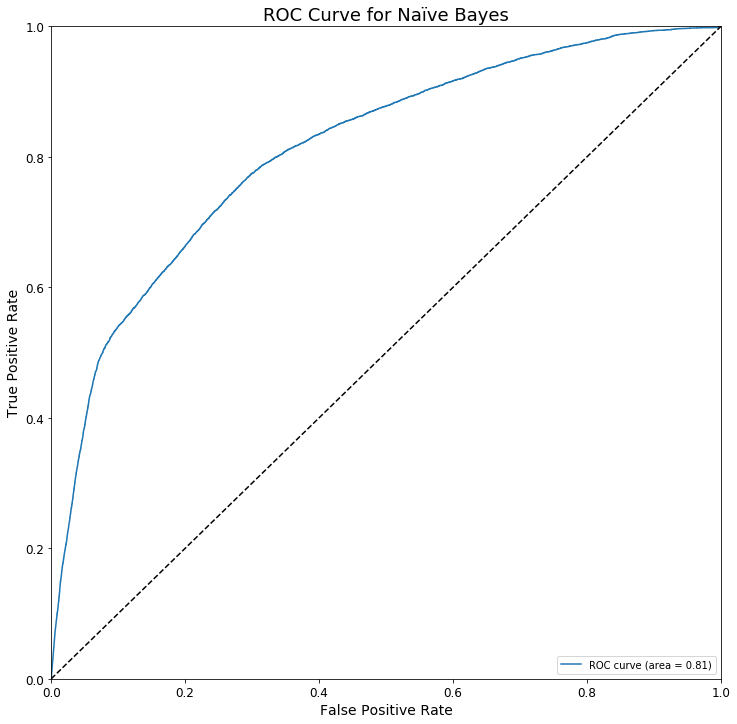

In [44]:
plt.figure(figsize = (12,12))
plt.tick_params(axis = 'both', which = 'major', labelsize = 12)
fpr, tpr, _ = metrics.roc_curve(y_test_class, class_models['naive_bayes']['probs'])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % class_models['naive_bayes']['ROC_AUC_test'])
plt.plot([0, 1], [0, 1], 'k--')  # coin toss line
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.title('ROC Curve for Naïve Bayes', fontsize = 18)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

In [45]:
X_train_abbrev = X_train.ix[:,[0, 1, 2, 4, 8, 9, 11, 17, 20]]
X_test_abbrev = X_test.ix[:,[0, 1, 2, 4, 8, 9, 11, 17, 20]]
np.random.seed(rand)
sample_size = 0.1
sample_idx = np.random.choice(X_test.shape[0],\
                              math.ceil(X_test.shape[0]*sample_size), replace=False)

dimred_methods = {
        #Decomposition
        'pca':{'method': decomposition.PCA(n_components=3)},  
        #Manifold Learning
        't-sne':{'method': manifold.TSNE(n_components=3)},
        #Variational Autoencoders
        'vae':{'method': cvae.CompressionVAE(X_train_abbrev.values,\
                                             dim_latent=3, tb_logging=False)}, 
    }

Total amount of data:  688137
Input feature dimension:  9
Calculating normalisation factors.
Normalisation factors calculated.
Total amount of data:  76460
Creating model.
Model created.
Setting up loss.
Loss set up.
Setting up session.
Session set up.
Trying to restore saved checkpoints from /Users/serg/EXTEND/PROJECTS/InterpretableMLBook/programming/Chapter3/temp ... No checkpoint found.
No model found to restore. Initialising new model.


In [46]:
for method_name in dimred_methods.keys():
    if method_name != 'vae':
        lowdim_data = dimred_methods[method_name]['method'].\
                        fit_transform(X_test_abbrev.values[sample_idx])
    else:
        fitted_model = dimred_methods[method_name]['method'].train()
        lowdim_data = fitted_model.embed(X_test_abbrev.values[sample_idx])
        dimred_methods[method_name]['fitted'] = fitted_model
    dimred_methods[method_name]['lowdim'] = lowdim_data

Starting queues.
Reader threads started.
step 0; epoch 0.00 - loss = 8.291, test_loss = 6.672, lr = 0.00100, (0.114 sec/step)
Storing checkpoint to /Users/serg/EXTEND/PROJECTS/InterpretableMLBook/programming/Chapter3/temp ... Done.
step 50; epoch 0.00 - loss = 4.514, test_loss = 5.425, lr = 0.00100, (0.100 sec/step)
step 100; epoch 0.01 - loss = 5.482, test_loss = 4.286, lr = 0.00100, (0.102 sec/step)
step 150; epoch 0.01 - loss = 5.828, test_loss = 4.098, lr = 0.00100, (0.099 sec/step)
step 200; epoch 0.02 - loss = 5.952, test_loss = 3.908, lr = 0.00100, (0.098 sec/step)
step 250; epoch 0.02 - loss = 3.208, test_loss = 3.768, lr = 0.00100, (0.096 sec/step)
step 300; epoch 0.03 - loss = 3.323, test_loss = 3.686, lr = 0.00100, (0.098 sec/step)
step 350; epoch 0.03 - loss = 9.218, test_loss = 3.618, lr = 0.00100, (0.096 sec/step)
step 400; epoch 0.04 - loss = 13.331, test_loss = 3.615, lr = 0.00100, (0.096 sec/step)
step 450; epoch 0.04 - loss = 3.587, test_loss = 3.594, lr = 0.00100, (0

In [47]:
y_names = {0:'Not Delayed', 1:'Delayed'}
def plot_3dim_decomposition(Z, y_labels, y_names):
    if len(y_names) > 2:
        cmap = 'plasma_r'
    else:
        cmap = 'viridis'
    fig, axs = plt.subplots(1, 3, figsize = (16,4))
    fig.subplots_adjust(hspace=0, wspace=0.3)
    scatter = axs[0].scatter(Z[:,0], Z[:,1],\
                             c=y_labels, alpha=0.5, cmap=cmap)
    legend = axs[0].legend(*scatter.legend_elements(), loc='best')
    for n in y_names.keys(): 
        legend.get_texts()[n].set_text(y_names[n])
    axs[0].set_xlabel('x', fontsize = 12)
    axs[0].set_ylabel('y', fontsize = 12)
    scatter = axs[1].scatter(Z[:,1], Z[:,2],\
                   c=y_labels, alpha=0.5, cmap=cmap)
    legend = axs[1].legend(*scatter.legend_elements(), loc='best')
    for n in y_names.keys(): 
        legend.get_texts()[n].set_text(y_names[n])
    axs[1].set_xlabel('y', fontsize = 12)
    axs[1].set_ylabel('z', fontsize = 12)
    axs[2].scatter(Z[:,0], Z[:,2],\
                   c=y_labels, alpha=0.5, cmap=cmap)
    legend = axs[2].legend(*scatter.legend_elements(), loc='best')
    for n in y_names.keys(): 
        legend.get_texts()[n].set_text(y_names[n])
    axs[2].set_xlabel('x', fontsize = 12)
    axs[2].set_ylabel('z', fontsize = 12)
    plt.show()

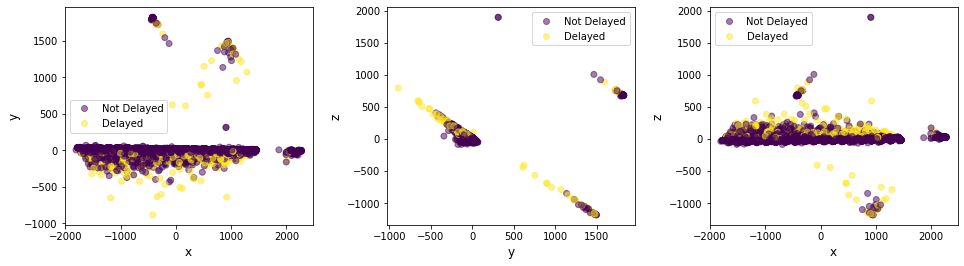

In [48]:
plot_3dim_decomposition(dimred_methods['pca']['lowdim'],\
                        y_test_class.values[sample_idx], y_names)

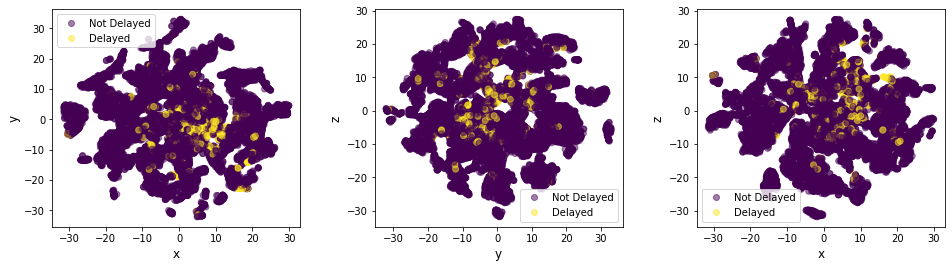

In [49]:
plot_3dim_decomposition(dimred_methods['t-sne']['lowdim'],\
                        y_test_class.values[sample_idx], y_names)

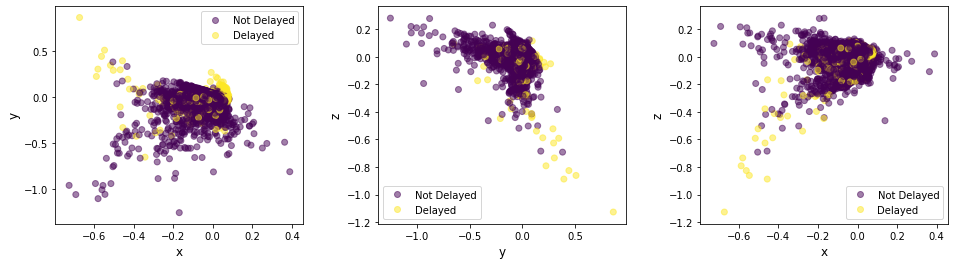

In [50]:
plot_3dim_decomposition(dimred_methods['vae']['lowdim'],\
                        y_test_class.values[sample_idx], y_names)

In [51]:
def encode_classification_error_vector(y_true, y_pred):
    error_vector = (y_true * 2) - y_pred
    error_vector = np.where(error_vector==0, 4, error_vector + 1)
    error_vector = np.where(error_vector==3, 0, error_vector - 1)
    error_vector = np.where(error_vector==3, error_vector, error_vector + 1)
    error_labels = {0:'FP', 1:'FN', 2:'TP', 3:'TN'}
    return error_vector, error_labels

In [52]:
y_test_class_samp = y_test_class.values[sample_idx]
y_test_pred_samp = class_models['ridge']['preds'][sample_idx]
error_vector, error_labels = encode_classification_error_vector(y_test_class_samp,\
                                                                y_test_pred_samp)

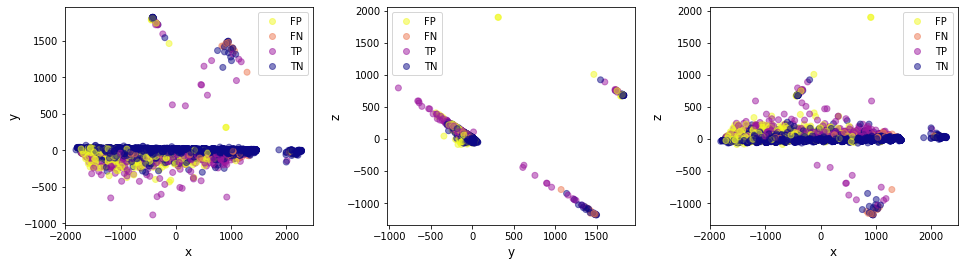

In [53]:
plot_3dim_decomposition(dimred_methods['pca']['lowdim'],\
                        error_vector, error_labels)

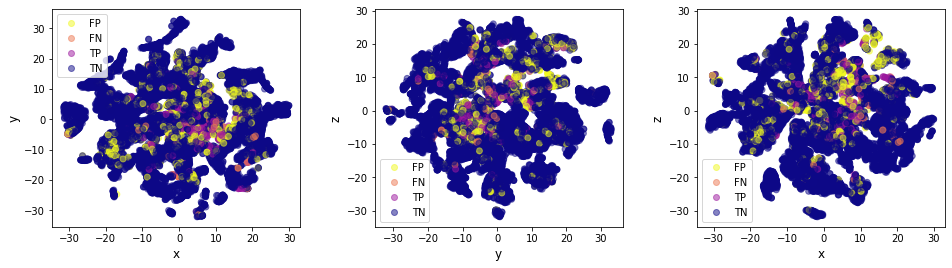

In [54]:
plot_3dim_decomposition(dimred_methods['t-sne']['lowdim'],\
                        error_vector, error_labels)

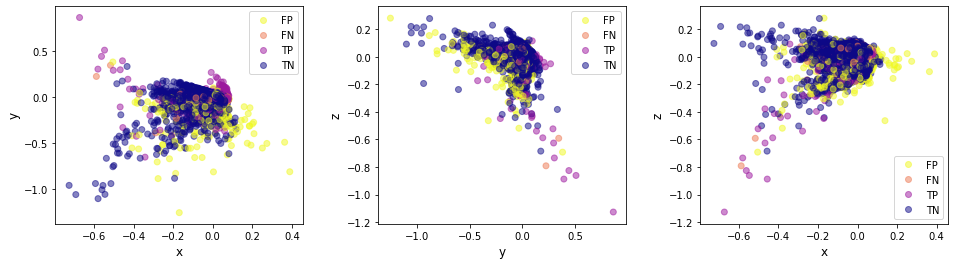

In [55]:
plot_3dim_decomposition(dimred_methods['vae']['lowdim'],\
                        error_vector, error_labels)

In [56]:
coefs_lm = reg_models['linear']['fitted'].coef_
intercept_lm = reg_models['linear']['fitted'].intercept_
print('coefficients:\t%s' % coefs_lm)
print('intercept:\t%s' % intercept_lm)

coefficients:	[ 4.54955677e-03 -5.25032459e-03  8.94123625e-01  1.25274473e-01
 -6.46799581e-04 -3.69913638e-04 -1.26272971e-02  6.76792565e-04
 -9.06353550e-01 -6.74052995e-01 -9.17398484e-01 -9.29841116e-01
 -1.52963280e-02  5.48174164e-04 -3.98350376e-02 -1.82132399e-02
 -4.69474192e-01  3.73843978e-01 -1.02908767e+00 -3.94898775e-01
  4.50115891e+01]
intercept:	-37.860211953237275


So now you know the formula looks something like this:

In [57]:
print('ŷ = %0.2f + %0.3fX₁ + %0.3fX₂ + %0.3fX₃ + ...' %\
      (intercept_lm, coefs_lm[0], coefs_lm[1], coefs_lm[2]))

ŷ = -37.86 + 0.005X₁ + -0.005X₂ + 0.894X₃ + ...


In [58]:
coef_df = pd.DataFrame({'feature':X_train.columns.values.tolist(),\
                        'coef': coefs_lm})
coef_df

,feature,coef
0,CRS_DEP_TIME,0.004550
1,DEP_TIME,-0.005250
2,DEP_DELAY,0.894124
3,TAXI_OUT,0.125274
4,WHEELS_OFF,-0.000647
5,CRS_ARR_TIME,-0.000370
6,CRS_ELAPSED_TIME,-0.012627
7,DISTANCE,0.000677
8,WEATHER_DELAY,-0.906354
9,NAS_DELAY,-0.674053


In [59]:
linreg_mdl = sm.OLS(y_train_reg.values, sm.add_constant(X_train.values))
linreg_mdl = linreg_mdl.fit()
linreg_mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 4.251e+05
Date:                Sun, 05 Jul 2020   Prob (F-statistic):               0.00
Time:                        12:23:32   Log-Likelihood:            -2.6574e+06
No. Observations:              764597   AIC:                         5.315e+06
Df Residuals:                  764575   BIC:                         5.315e+06
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -37.8602      0.125   -301.757      0.000     -38.106     -37.614
x1             0.0045   7.24e-05     62.867      0.000       0.004       0.005
x2            -0.0053   9.19e-05    -57.112      0.000      -0.005      -0.005
x3             0.8941      0.000   2951.087      0.000       0.894       0.895
x4             0.1253      0.001    104.117      0.000       0.123       0.128
x5            -0.0006    6.7e-05     -9.647      0.000      -0.001      -0.001
x6            -0.0004   2.18e-05    -16.938      0.000      -0.000      -0.000
x7            -0.0126      0.001    -19.137      0.000      -0.014      -0.011
x8             0.0007   8.02e-05      8.434      0.000       0.001       0.001
x9            -0.9064      0.001   -995.373      0.000      -0.908      -0.905
x10           -0.6741      0.001   -829.130      0.000      -0.676      -0.672
x11           -0.9174      0.005   -167.855      0.000      -0.928      -0.907
x12           -0.9298      0.001  -1827.027      0.000      -0.931      -0.929
x13           -0.0153      0.000    -47.726      0.000      -0.016      -0.015
x14            0.0005      0.000      1.652      0.099      -0.000       0.001
x15           -0.0398      0.003    -15.084      0.000      -0.045      -0.035
x16           -0.0182      0.004     -4.060      0.000      -0.027      -0.009
x17           -0.4695      0.017    -27.345      0.000      -0.503      -0.436
x18            0.3738      0.013     28.384      0.000       0.348       0.400
x19           -1.0291      0.027    -38.588      0.000      -1.081      -0.977
x20           -0.3949      0.026    -15.040      0.000      -0.446      -0.343
x21           45.0116      0.117    384.076      0.000      44.782      45.241
==============================================================================
Omnibus:                   211110.425   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         24354337.307
Skew:                           0.098   Prob(JB):                         0.00
Kurtosis:                      30.648   Cond. No.                     5.69e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.69e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [60]:
summary_df = linreg_mdl.summary2().tables[1]
summary_df = summary_df.drop(['const']).reset_index(drop=True) 
names_df = pd.DataFrame({'feature':X_train.columns.values})
summary_df = pd.concat([names_df, summary_df], axis=1)
summary_df['t_abs'] = abs(summary_df['t'])
summary_df.sort_values(by='t_abs', ascending=False).style.\
    background_gradient(cmap='plasma_r', low=0, high=0.1, subset=['P>|t|']).\
    background_gradient(cmap='plasma_r', low=0, high=0.1, subset=['t_abs'])

,feature,Coef.,Std.Err.,t,P>|t|,[0.025,0.975],t_abs
2,DEP_DELAY,0.894124,0.000302981,2951.09,0,0.89353,0.894717,2951.09
11,LATE_AIRCRAFT_DELAY,-0.929841,0.000508937,-1827.03,0,-0.930839,-0.928844,1827.03
8,WEATHER_DELAY,-0.906354,0.000910567,-995.373,0,-0.908138,-0.904569,995.373
9,NAS_DELAY,-0.674053,0.000812964,-829.13,0,-0.675646,-0.67246,829.13
20,PCT_ELAPSED_TIME,45.0116,0.117195,384.076,0,44.7819,45.2413,384.076
10,SECURITY_DELAY,-0.917398,0.00546544,-167.855,0,-0.928111,-0.906686,167.855
3,TAXI_OUT,0.125274,0.00120321,104.117,0,0.122916,0.127633,104.117
0,CRS_DEP_TIME,0.00454956,7.23674e-05,62.8675,0,0.00440772,0.00469139,62.8675
1,DEP_TIME,-0.00525032,9.19302e-05,-57.1121,0,-0.0054305,-0.00507014,57.1121
12,DEP_AFPH,-0.0152963,0.000320506,-47.7256,0,-0.0159245,-0.0146681,47.7256


In [61]:
coefs_ridge = reg_models['ridge']['fitted'].coef_
coef_ridge_df = pd.DataFrame({'feature':X_train.columns.values.tolist(),\
                        'coef_linear': coefs_lm,\
                        'coef_ridge': coefs_ridge})
coef_ridge_df.style.\
    background_gradient(cmap='viridis_r', low=0.3, high=0.2, axis=1)

,feature,coef_linear,coef_ridge
0,CRS_DEP_TIME,0.00454956,0.00501961
1,DEP_TIME,-0.00525032,-0.00441738
2,DEP_DELAY,0.894124,0.894292
3,TAXI_OUT,0.125274,0.125165
4,WHEELS_OFF,-0.0006468,0.000232365
5,CRS_ARR_TIME,-0.000369914,-0.00189765
6,CRS_ELAPSED_TIME,-0.0126273,-0.0125826
7,DISTANCE,0.000676793,0.0021406
8,WEATHER_DELAY,-0.906354,-0.906168
9,NAS_DELAY,-0.674053,-0.67396


In [62]:
num_alphas = 100
alphas = np.logspace(0, 13, num_alphas)
alphas_coefs = []
for alpha in alphas:
    ridge = linear_model.Ridge(alpha=alpha).fit(X_train, y_train_reg)
    alphas_coefs.append(ridge.coef_[:20])

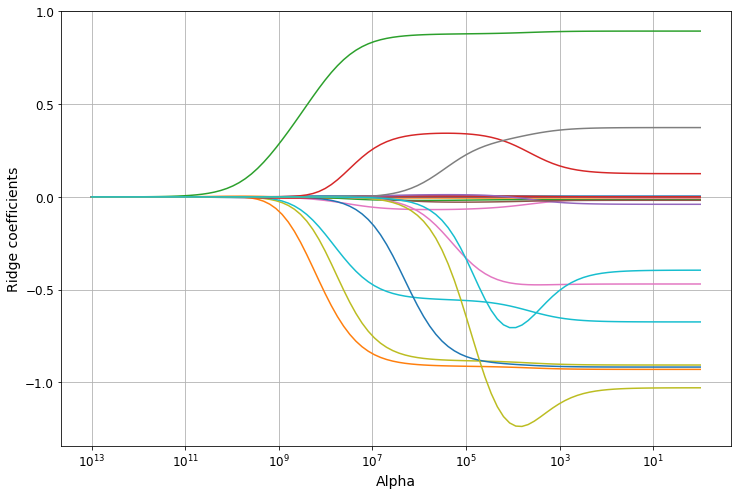

In [63]:
plt.figure(figsize = (12,8))
plt.gca().invert_xaxis()
plt.tick_params(axis = 'both', which = 'major', labelsize = 12)
plt.plot(alphas, alphas_coefs)
plt.xscale("log")
plt.xlabel('Alpha', fontsize = 14)
plt.ylabel('Ridge coefficients', fontsize = 14)
plt.grid()
plt.show()

In [64]:
reg_models['linear_poly']['fitted'].get_params()['linearregression'].coef_.shape[0]

253

In [65]:
reg_models['linear_interact']['fitted'].get_params()['linearregression'].coef_.shape[0]

232

In [66]:
coefs_log = class_models['logistic']['fitted'].coef_
intercept_log = class_models['logistic']['fitted'].intercept_
print('coefficients:\t%s' % coefs_log)
print('intercept:\t%s' % intercept_log)

coefficients:	[[-6.31114061e-04 -1.48979793e-04  2.01484473e-01  1.32897749e-01
   1.31740116e-05 -3.83761619e-04 -7.60281290e-02  8.17495461e-03
  -2.06253161e-01 -1.73282843e-01 -2.33809598e-01 -2.01747559e-01
  -4.48392292e-03 -9.07649800e-03 -5.37997715e-02 -7.97830128e-02
  -1.87592571e-01 -6.38273927e-02  2.56287199e-02 -2.07823738e-01
  -3.23773254e-02]]
intercept:	[-0.20139626]


In [67]:
stdv = np.std(X_train, 0)
abs(coefs_log.reshape(21,) * stdv).sort_values(ascending=False)

DEP_DELAY             8.918590
CRS_ELAPSED_TIME      6.034794
DISTANCE              5.309037
LATE_AIRCRAFT_DELAY   4.985519
NAS_DELAY             2.387845
WEATHER_DELAY         2.155292
TAXI_OUT              1.311593
SECURITY_DELAY        0.383242
ARR_AFPH              0.320974
CRS_DEP_TIME          0.316445
CRS_ARR_TIME          0.202677
DEP_MONTH             0.183604
DEP_DOW               0.159450
DEP_AFPH              0.158977
DEP_RFPH              0.105978
DEST_HUB              0.101092
DEP_TIME              0.076711
ARR_RFPH              0.046042
ORIGIN_HUB            0.012460
WHEELS_OFF            0.006806
PCT_ELAPSED_TIME      0.003410
dtype: float64

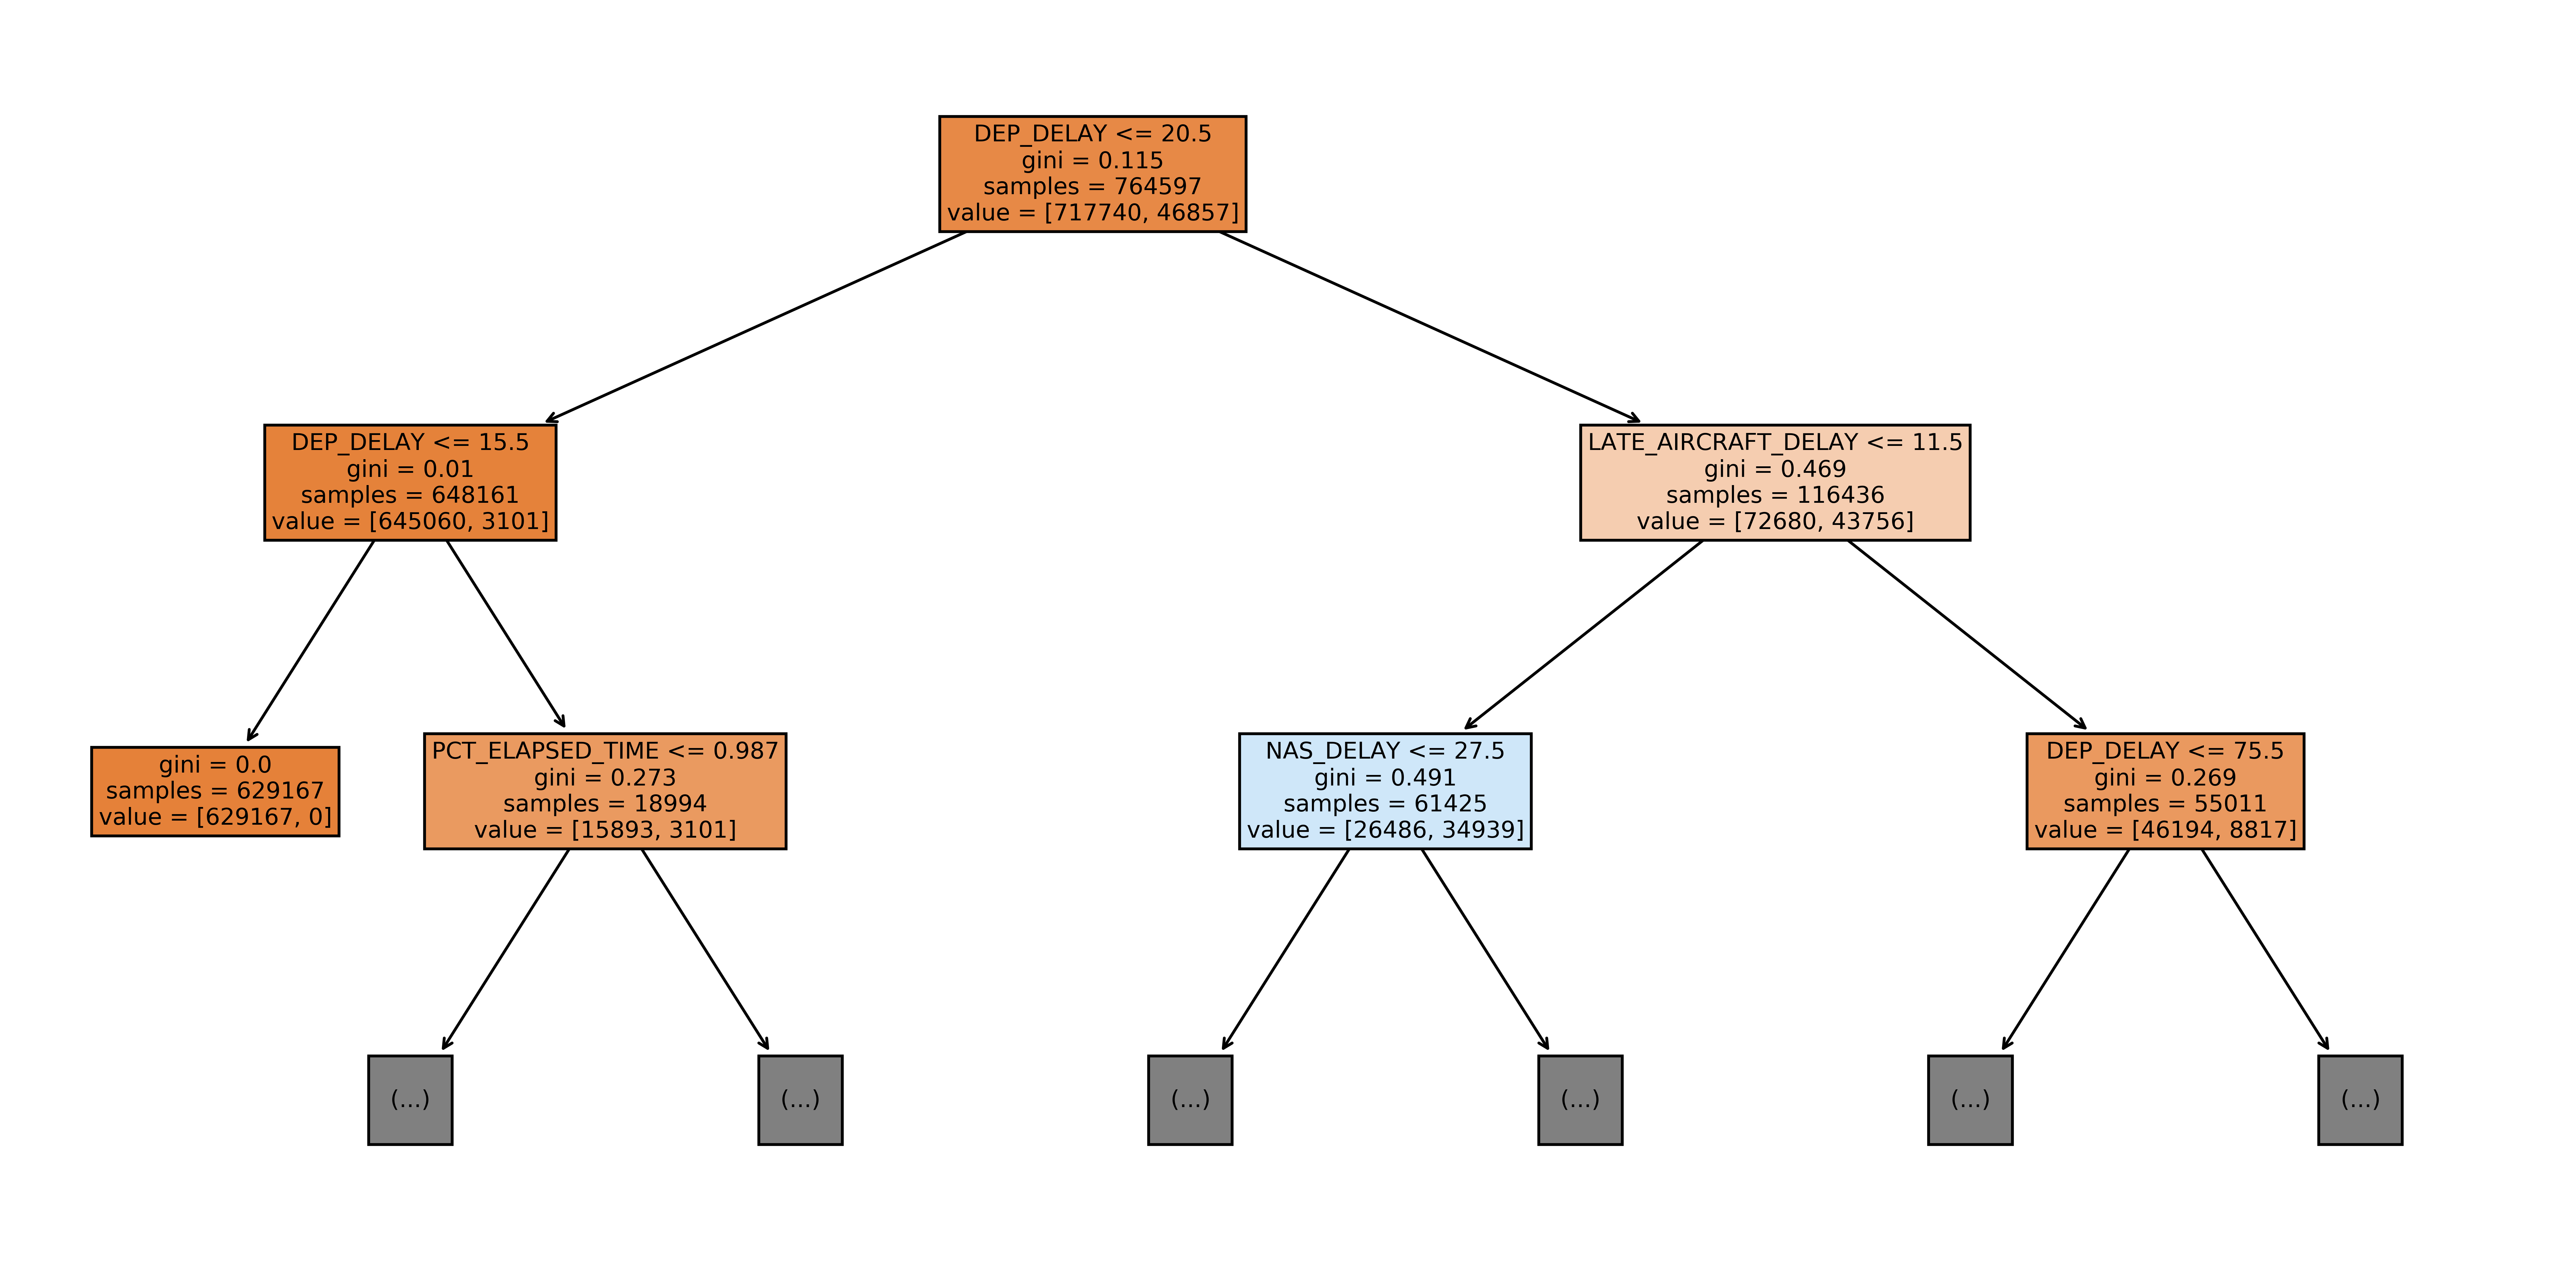

In [68]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (16,8), dpi=600)
tree.plot_tree(class_models['decision_tree']['fitted'],\
               feature_names=X_train.columns.values.tolist(), filled = True, max_depth=2)
fig.show()

In [69]:
text_tree = tree.export_text(class_models['decision_tree']['fitted'],\
               feature_names=X_train.columns.values.tolist())
print(text_tree)

|--- DEP_DELAY <= 20.50
|   |--- DEP_DELAY <= 15.50
|   |   |--- class: 0
|   |--- DEP_DELAY >  15.50
|   |   |--- PCT_ELAPSED_TIME <= 0.99
|   |   |   |--- PCT_ELAPSED_TIME <= 0.98
|   |   |   |   |--- PCT_ELAPSED_TIME <= 0.96
|   |   |   |   |   |--- CRS_ELAPSED_TIME <= 65.50
|   |   |   |   |   |   |--- PCT_ELAPSED_TIME <= 0.94
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- PCT_ELAPSED_TIME >  0.94
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- CRS_ELAPSED_TIME >  65.50
|   |   |   |   |   |   |--- PCT_ELAPSED_TIME <= 0.95
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- PCT_ELAPSED_TIME >  0.95
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- PCT_ELAPSED_TIME >  0.96
|   |   |   |   |   |--- CRS_ELAPSED_TIME <= 140.50
|   |   |   |   |   |   |--- DEP_DELAY <= 18.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- DEP_DELAY >  18.50
|   |   |   |   |   |   |   |--- class: 0
|   |   

In [70]:
dt_imp_df = pd.DataFrame({'feature':X_train.columns.values.tolist(),\
                        'importance': class_models['decision_tree']['fitted'].feature_importances_}).\
            sort_values(by='importance', ascending=False)
dt_imp_df

,feature,importance
2,DEP_DELAY,0.527482
11,LATE_AIRCRAFT_DELAY,0.199153
20,PCT_ELAPSED_TIME,0.105381
8,WEATHER_DELAY,0.101649
9,NAS_DELAY,0.062758
10,SECURITY_DELAY,0.001998
7,DISTANCE,0.000993
6,CRS_ELAPSED_TIME,0.000281
3,TAXI_OUT,0.000239
4,WHEELS_OFF,0.000035


In [71]:
rulefit_df = reg_models['rulefit']['fitted'].get_rules()
rulefit_df = rulefit_df[rulefit_df.coef != 0].sort_values(by="importance", ascending=False)
rulefit_df

,rule,type,coef,support,importance
67,DEP_DELAY > 344.0 & LATE_AIRCRAFT_DELAY <= 222...,rule,207.222138,0.001684,8.495267
81,DEP_DELAY > 477.5 & LATE_AIRCRAFT_DELAY <= 333.5,rule,167.438743,0.001122,5.606260
28,DEP_DELAY > 490.5 & WEATHER_DELAY > 255.0,rule,-333.536096,0.000187,4.561291
11,LATE_AIRCRAFT_DELAY,linear,-0.382982,1.000000,4.487448
2,DEP_DELAY,linear,0.162711,1.000000,4.256935
...,...,...,...,...,...
15,DEP_DOW,linear,0.003385,1.000000,0.006765
132,DEP_DELAY > 344.0 & LATE_AIRCRAFT_DELAY > 222.5,rule,-0.246392,0.000748,0.006737
108,DEP_DELAY <= 1032.5 & ARR_RFPH <= 0.5607937276...,rule,-0.189074,0.000374,0.003656
153,DEP_DELAY > 47.5 & DEP_DELAY <= 300.0 & LATE_A...,rule,0.019294,0.033857,0.003490


In [72]:
X_test.ix[721043,:]

CRS_DEP_TIME           655.000000
DEP_TIME              1055.000000
DEP_DELAY              240.000000
TAXI_OUT                35.000000
WHEELS_OFF            1130.000000
CRS_ARR_TIME           914.000000
CRS_ELAPSED_TIME       259.000000
DISTANCE              1660.000000
WEATHER_DELAY            0.000000
NAS_DELAY               22.000000
SECURITY_DELAY           0.000000
LATE_AIRCRAFT_DELAY    221.000000
DEP_AFPH                90.800000
ARR_AFPH                40.434783
DEP_MONTH               10.000000
DEP_DOW                  4.000000
DEP_RFPH                 0.890196
ARR_RFPH                 1.064073
ORIGIN_HUB               1.000000
DEST_HUB                 0.000000
PCT_ELAPSED_TIME         1.084942
Name: 721043, dtype: float64

In the `y_test_class` labels for flight #721043 we can tell that it was delayed:

In [73]:
y_test_class.ix[721043,:]

1

In [74]:
class_models['knn']['preds'][X_test.index.get_loc(721043)]

0

In [75]:
class_models['knn']['fitted'].kneighbors(X_test.ix[721043,:].values.reshape(1,21), 7)

(array([[143.3160128 , 173.90740076, 192.66705727, 211.57109221,
         243.57211853, 259.61593993, 259.77507391]]),
 array([[105172, 571912,  73409,  89450,  77474, 705972, 706911]]))

In [76]:
y_train_class.iloc[[105172, 571912,  73409,  89450,  77474, 705972, 706911]]

3813      0
229062    1
283316    0
385831    0
581905    1
726784    1
179364    0
Name: CARRIER_DELAY, dtype: int64

In [77]:
class_models['knn']['fitted'].effective_metric_

'euclidean'

In [78]:
class_models['naive_bayes']['fitted'].class_prior_

array([0.93871674, 0.06128326])

In [79]:
class_models['naive_bayes']['fitted'].sigma_

array([[2.50123026e+05, 2.61324730e+05, 9.21572605e+02, 9.58074414e+01,
        2.62606651e+05, 2.75433641e+05, 6.30102550e+03, 4.22470414e+05,
        1.11234714e+02, 1.91877186e+02, 2.80302201e+00, 5.06561612e+02,
        1.26123968e+03, 1.25314386e+03, 1.17347897e+01, 3.99182427e+00,
        2.08339528e-01, 3.48655340e-01, 2.39015406e-01, 2.34996222e-01,
        1.13475535e-02],
       [2.60629652e+05, 2.96009867e+05, 1.19307931e+04, 1.20404927e+02,
        3.08568277e+05, 3.28574000e+05, 6.29066219e+03, 4.10198938e+05,
        7.79140423e+01, 1.56184090e+02, 9.12112286e-01, 2.11279954e+03,
        1.14839167e+03, 1.09023147e+03, 1.02717682e+01, 4.03039988e+00,
        1.99929921e+00, 3.08997044e+00, 1.77750796e-01, 2.50208354e-01,
        1.38936741e-02]])

In [80]:
class_models['naive_bayes']['fitted'].theta_

array([[1.30740577e+03, 1.31006271e+03, 5.14196506e+00, 1.87120810e+01,
        1.33552258e+03, 1.48438931e+03, 1.70734929e+02, 1.01824369e+03,
        7.39971299e-01, 2.85434558e+00, 2.41814585e-02, 4.14674395e+00,
        5.45864877e+01, 5.39873058e+01, 6.55049043e+00, 2.95054059e+00,
        1.09377996e+00, 1.09644787e+00, 6.06800513e-01, 6.24199571e-01,
        9.71131781e-01],
       [1.41305545e+03, 1.48087887e+03, 8.45867640e+01, 1.99378321e+01,
        1.49409412e+03, 1.54821862e+03, 1.72229998e+02, 1.04363666e+03,
        4.50733082e-01, 4.71991378e+00, 2.11281132e-02, 1.40744819e+01,
        6.14731036e+01, 4.26486417e+01, 6.73427663e+00, 3.03790255e+00,
        1.25429654e+00, 1.36373798e+00, 7.69575517e-01, 4.85391724e-01,
        9.83974416e-01]])

In [81]:
#Make new abbreviated versions of datasets
feature_samp = ['DEP_DELAY', 'LATE_AIRCRAFT_DELAY', 'PCT_ELAPSED_TIME', 'WEATHER_DELAY',\
                'NAS_DELAY', 'SECURITY_DELAY', 'DISTANCE', 'CRS_ELAPSED_TIME']
X_train_abbrev2 = X_train[feature_samp]
X_test_abbrev2 = X_test[feature_samp]
#For sampling among observations
np.random.seed(rand)
sample2_size = 0.1
sample2_idx = np.random.choice(X_train.shape[0], math.ceil(X_train.shape[0]*sample2_size), replace=False)

In [82]:
ebm_mdl = ExplainableBoostingClassifier()
ebm_mdl.fit(X_train_abbrev2.iloc[sample2_idx], y_train_class.iloc[sample2_idx])

ExplainableBoostingClassifier(binning_strategy='quantile', data_n_episodes=2000,
                              early_stopping_run_length=50,
                              early_stopping_tolerance=1e-05,
                              feature_names=['DEP_DELAY', 'LATE_AIRCRAFT_DELAY',
                                             'PCT_ELAPSED_TIME',
                                             'WEATHER_DELAY', 'NAS_DELAY',
                                             'SECURITY_DELAY', 'DISTANCE',
                                             'CRS_ELAPSED_TIME'],
                              feature_step_n_inner_bags=0,
                              feature_types=['continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous'],
                              holdout_size=0.15, holdout_split=0.15,
              

In [83]:
show(ebm_mdl.explain_global())

<!-- http://127.0.0.1:7190/5456699920/ -->

In [84]:
ebm_lcl = ebm_mdl.explain_local(X_test_abbrev2.iloc[76:77],\
                                y_test_class[76:77], name='EBM')
show(ebm_lcl)

<!-- http://127.0.0.1:7190/5462062032/ -->

In [85]:
ebm_perf = ROC(ebm_mdl.predict_proba).\
                            explain_perf(X_test_abbrev2.iloc[sample_idx],\
                                         y_test_class.iloc[sample_idx], name='EBM')
show(ebm_perf)

<!-- http://127.0.0.1:7190/5505386576/ -->

In [86]:
sr_mdl = SkopeRules(n_estimators=200, precision_min=0.2, recall_min=0.01,\
                    n_jobs=-1, random_state=rand, max_depth=7,\
                    feature_names=X_train_abbrev2.columns)
sr_mdl.fit(X_train_abbrev2.iloc[sample2_idx], y_train_class.iloc[sample2_idx])

SkopeRules(bootstrap=False, bootstrap_features=False,
           feature_names=Index(['DEP_DELAY', 'LATE_AIRCRAFT_DELAY', 'PCT_ELAPSED_TIME', 'WEATHER_DELAY',
       'NAS_DELAY', 'SECURITY_DELAY', 'DISTANCE', 'CRS_ELAPSED_TIME'],
      dtype='object'),
           max_depth=7, max_depth_duplication=None, max_features=1.0,
           max_samples=0.8, max_samples_features=1.0, min_samples_split=2,
           n_estimators=200, n_jobs=-1, precision_min=0.2, random_state=9,
           recall_min=0.01, verbose=0)

In [87]:
sr_y_test_prob = sr_mdl.score_top_rules(X_test_abbrev2.iloc[sample_idx])
sr_y_test_pred = np.where(sr_y_test_prob > 0.5, 1, 0)

In [88]:
len(sr_mdl.rules_)

1517

In [89]:
sr_mdl.rules_[0:5]

[('DEP_DELAY > 39.5 and LATE_AIRCRAFT_DELAY <= 12.5 and WEATHER_DELAY <= 12.0 and NAS_DELAY <= 27.5 and SECURITY_DELAY <= 8.5',
  (0.959051724137931, 0.4777241009125067, 2)),
 ('DEP_DELAY > 39.5 and LATE_AIRCRAFT_DELAY <= 12.5 and WEATHER_DELAY <= 12.0 and NAS_DELAY <= 27.5 and SECURITY_DELAY <= 16.5',
  (0.9590878374516092, 0.4757740862307305, 6)),
 ('DEP_DELAY > 39.5 and LATE_AIRCRAFT_DELAY <= 11.5 and WEATHER_DELAY <= 12.0 and NAS_DELAY <= 27.5 and SECURITY_DELAY <= 20.5',
  (0.9598373709847126, 0.4728846642569354, 6)),
 ('DEP_DELAY > 39.5 and LATE_AIRCRAFT_DELAY <= 12.5 and WEATHER_DELAY <= 12.5 and NAS_DELAY <= 27.5 and SECURITY_DELAY <= 16.5',
  (0.9569012547735952, 0.4712520150456744, 2)),
 ('DEP_DELAY > 39.5 and LATE_AIRCRAFT_DELAY <= 11.5 and WEATHER_DELAY <= 12.0 and NAS_DELAY <= 27.5 and SECURITY_DELAY <= 19.0',
  (0.9589380988822661, 0.4700764303305863, 4))]

In [90]:
print('actual: %s, predicted: %s' % (y_test_class.iloc[76], sr_y_test_pred[76]))

actual: 1, predicted: 0


In [91]:
sr_mdl.decision_function(X_test_abbrev2.iloc[76:77])

array([18.23328729])

In [92]:
print('accuracy: %.3g, recall: %.3g, roc auc: %.3g, f1: %.3g, mcc: %.3g' %\
      (metrics.accuracy_score(y_test_class.iloc[sample_idx], sr_y_test_pred),\
       metrics.recall_score(y_test_class.iloc[sample_idx], sr_y_test_pred),\
       metrics.roc_auc_score(y_test_class.iloc[sample_idx], sr_y_test_prob),\
       metrics.f1_score(y_test_class.iloc[sample_idx], sr_y_test_pred),\
       metrics.matthews_corrcoef(y_test_class.iloc[sample_idx], sr_y_test_pred)))

accuracy: 0.961, recall: 0.981, roc auc: 0.984, f1: 0.748, mcc: 0.753


In [93]:
etime = timeit.default_timer()
print(">> ", round((etime - stime)/60, 3), " Minutes")

>>  41.407  Minutes
